# Análisis deudores BCRA (parte 2)
## junio de 2020

Autor: Carlos A. Crespo (lvccrespo@gmail.com)

A pedido del público ¿? retomamos el análisis de las empresas deudoras en Argentina y profundizamos en algunos aspectos.

[Aquí](https://github.com/cacrespo/analisis_BCRA/blob/master/analisis%20deudores%20BCRA%20-%20parte%201.ipynb) se encuentra el desarrollo de la primera parte.

Contábamos con un dataset con la info de las empresas a febrero de 2020. Cada CUIT con su deuda en cada institución financiera de la República Argentina.

## Distintos enfoques para ver ¿lo mismo?
En el trabajo anterior **obtuvimos resultados para cada institución**: "deuda total", "deuda promedio", etc. Se podría decir que obtuvimos resultados "mirando" la información desde los ojos de los bancos. 

Ahora bien, podríamos **revisar los mismos datos desde una perspectiva distinta**, la perspectiva de las empresas: **¿a cuántos bancos le deben? ¿cuál es la deuda promedio por empresa?**

Para hacer todo esto **es necesario tener claro cuál es el nivel de detalle**, de "granularidad" de los datos, y **cuál es el nivel que necesitamos**. Y finalmente *cómo dialogan cada uno de estos niveles*.

Teníamos millones de filas y agregamos todo para cada una de las entidades financieras. Para calcular el total de deuda, tomamos cada fila con el valor de deuda con la entidad en cuestión y para todo ese grupo de filas obtuvimos un sólo valor final con la suma. Ahora vamos a dar un paso más y trabajar vinculando estos niveles que mencionaba anteriormente.

- Si quisierás hacer esto en SPSS deberías explorar el comando `AGGREGATE` (que tiene todo el sentido del mundo porque es una "agregación").
- Si lo trabajás en Tableau, hay que bucear en lo que ellos denominan "expresiones de nivel de detalle" (*LOD* por las siglas en inglés). Acá el comando no es tan intuitivo: `FIXED`.
- Si lo hacés a mano con un ábaco: te deseo suerte.

En pandas combinamos `groupby` y `agg` (casi casi SQL). Vamos a generar tablas __agrupando por__ y __agregando__ con las operaciones aritméticas que necesitemos:

In [1]:
import pandas as pd

# Levamtamos el dataset que armamos previamente (¿no vas a correr todo de nuevo?)
df = pd.read_csv("deudores_juridicas_202002.csv")

# Calculamos para cada CUIT con cuántos bancos tiene deuda y el volumen.
df_empresas = df.groupby('cuitcuil').agg({'totalprestamos':['max', 'sum']  , 'entidad': 'nunique'}) # Incluimos 'max' para un cálculo posterior

# Ajustamos "etiquetas" de columnas para visualizar mejor
df_empresas = df_empresas.reset_index()
df_empresas.columns = ["cuitcuil",  "Deuda máxima en $ MM", "Prestamos Total en $ MM","Número de Acreedores"]

# Revisamos los resultados
df_empresas.head()

,cuitcuil,Deuda máxima en $ MM,Prestamos Total en $ MM,Número de Acreedores
0,30086400096,0.021,0.021,1
1,30259329996,0.007,0.007,1
2,30322242812,0.012,0.012,1
3,30500000127,4.165,6.213,5
4,30500001115,1.486,2.209,2


Ya tenemos una tabla con todos los cuits, el volumen total de deuda, la deuda máxima entre todas las entidades y cuántos acreedores tienen. Por ejemplo para la última fila que visualizamos debe un total de \\$ 2.209 MM entre dos bancos y al que más le debe lo hace por \\$ 1.486 MM.

#### Comencemos a explorar los resultados: ¿a cuántas entidades le debe cada empresa en promedio?

In [2]:
# Nos ubicamos a nivel detalle empresas y obtenemos algunos valores descriptivos mediante describe()

df_empresas[df_empresas.columns[2:]].describe()

,Prestamos Total en $ MM,Número de Acreedores
count,201338.000000,201338.000000
mean,7.718074,1.613372
std,228.121328,1.366594
min,0.000000,1.000000
25%,0.003000,1.000000
50%,0.045000,1.000000
75%,0.334000,2.000000
max,53826.226000,31.000000


Perfecto. Ya tenemos las respuestas! El promedio de deuda por empresa es $ 7.7 MM y se endeudan con 1.6 bancos.

Momeeeeeento! Si observamos con detenimiento vemos que **para ambos indicadores hay valores "[muy extremos](https://es.wikipedia.org/wiki/Valor_at%C3%ADpico)"**. 
Por ej. el 75% de los prestamos tiene valores menores a \\$ 334.000 y ¿el promedio es \\$ 7.7 MM?. El máximo en toda la muestra es casi \\$ 54.000 millones (WTF!).

Veamos cómo se ve en un [boxplot](https://es.wikipedia.org/wiki/Diagrama_de_caja):

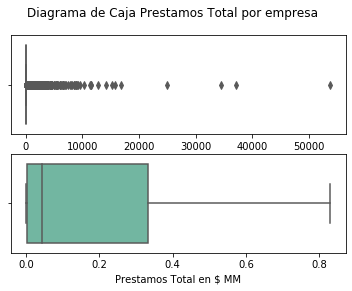

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax =plt.subplots(2,1) # dos gráficos en una sola columna
fig.suptitle('Diagrama de Caja Prestamos Total por empresa')

sns.boxplot(data=df_empresas,x="Prestamos Total en $ MM", orient="h",showfliers=True , palette="Set2",ax=ax[0]); 
sns.boxplot(data=df_empresas,x="Prestamos Total en $ MM", orient="h",showfliers=False , palette="Set2",ax=ax[1]); 

`"showfliers=False"` excluye de la visualización los outliers. En este caso el gráfico de abajo sería como un zoom del gráfico de arriba.

En número de acreedores pasa algo parecido: casi toda la muestra tiene menos de 3 acreedores y el máximo 31. Pero vamos a enfocarnos en el volumen de deuda.

Intuitivamente -entre otras cosas- iría a ver esos casos puntuales: qué CUITS son, qué valores tienen en el resto de los campos. ¿Será un problema de carga? ¿habrá algún problema en la base? 

Hay numerosas maneras de abordar el tratamiento de los "outliers". Podríamos por ejemplo quedarnos con la [media recortada](https://es.wikipedia.org/wiki/Media_truncada), quitar casos según algún criterio externo a los datos, etc.

A titulo ilustrativo veamos cómo se transforma la muestra luego de excluir todos los casos que se desvíen mucho de la media. Básicamente normalizamos los resultados y después filtramos con la condición hasta +-1.96 desvíos (¿te suena de algún lado ese valor?). 

In [4]:
from scipy import stats
import numpy as np

c = np.abs(stats.zscore(df_empresas["Prestamos Total en $ MM"])) < 1.96 # creamos una serie con True False para filtrar el dataset

# con la nueva selección de casos vemos de nuevo el resumen de resultados. 
# el [2:] es porque tomamos desde la 3er columna en adelante (el orden arranca en 0)

df_empresas[df_empresas.columns[2:]][c].describe()

,Prestamos Total en $ MM,Número de Acreedores
count,200887.000000,200887.000000
mean,2.585876,1.596390
std,17.677062,1.299253
min,0.000000,1.000000
25%,0.003000,1.000000
50%,0.045000,1.000000
75%,0.329000,2.000000
max,453.890000,31.000000


Parece mucho mejor. *Ahora el promedio de deuda es \\$ 2.5 MM y el máximo en \\$ 454 MM*. El número de acreedores (1.6) no parece alterarse demasiado.

Sin embargo, dado que el 75% de los casos poseen valores hasta \\$ 329.000 y ***tenemos valores tan extremos: ¿tiene sentido enfocarnos en la media? ¿es adecuado considerar todos los casos "dentro de la misma bolsa"?***

En situaciones como esta recomiendo el enfoque de [Lerner](https://www.youtube.com/watch?v=plLaNCLG-JE).

Para terminar vale la pena hacer un cruce entre los dos indicadores. Parece que los valores extremos no son exclusividad de las empresas endeudadas con muchos bancos:

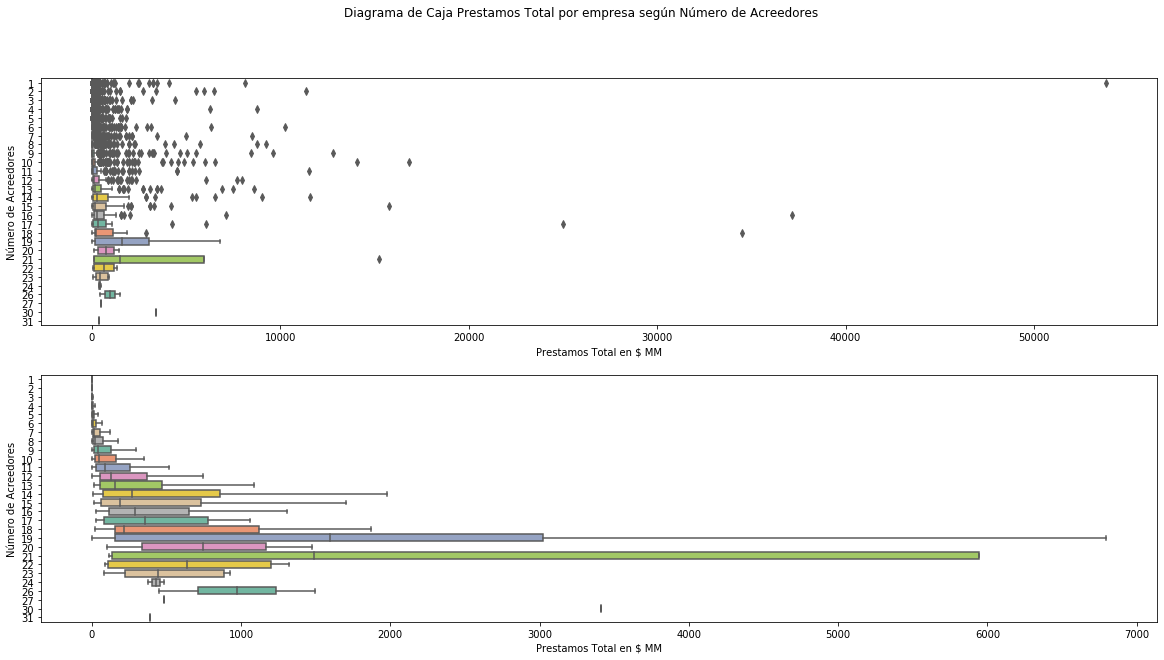

In [5]:
fig, ax =plt.subplots(2,1,figsize=(20, 10)) # dos gráficos en una sola columna y agrandamos un poco.
fig.suptitle('Diagrama de Caja Prestamos Total por empresa según Número de Acreedores')

sns.boxplot(data=df_empresas,y='Número de Acreedores',x="Prestamos Total en $ MM", orient="h",
            showfliers=True , palette="Set2",ax=ax[0]);
sns.boxplot(data=df_empresas,y='Número de Acreedores',x="Prestamos Total en $ MM", orient="h",
            showfliers=False , palette="Set2",ax=ax[1]);


#### ¿Cuál es el banco que se lleva el mayor volumen de deuda de cada empresa?
Ahora bien, resulta que dificilmente una empresa tome deuda equitativamente con cada banco. Incluimos en los cálculos de agregación el valor máximo de deuda, y con ello hacemos el ejercicio de identificar cuál es el banco que se lleva el mayor volumen de cada CUIT (podría ser más de uno. Si fuera 50% y 50% entrarían las dos instituciones).

Para abordar este interrogante **tenemos que hacer dialogar niveles de detalle distintos: necesitamos identificar el máximo deudor por empresa y luego consolidar para cada banco todos sus deudores**.

In [6]:
# el dataset con las empresas y el detalle deuda máxima y número de acreedores que contruimos ["NIVEL 1"]
df1 = df_empresas[['cuitcuil', "Deuda máxima en $ MM","Número de Acreedores"]]

# el dataset original con los campos entidad y monto de cada una de las deudas. ["NIVEL 0"]
df2 = df[['cuitcuil', "entidad", "totalprestamos"]]

# los juntamos en df3
df3 = pd.merge(df2,df1,on='cuitcuil',how='left')

# agregamos una columna donde identificamos si la entidad es máximo acreedor
df3["máximo acreedor"] = (df3["Deuda máxima en $ MM"] == df3["totalprestamos"]) * 1

df3.head()

,cuitcuil,entidad,totalprestamos,Deuda máxima en $ MM,Número de Acreedores,máximo acreedor
0,30500041443,7,0.002,0.074,3,0
1,30500064230,7,0.002,38.426,5,0
2,30500095764,7,0.002,0.658,3,0
3,30500145966,7,0.002,0.002,1,1
4,30500689443,7,0.020,5.574,3,0


En esta linea:
`(df3["Deuda máxima en $ MM"] == df3["totalprestamos"]) * 1`

multiplicamos por 1 un resultado *booleano* (true o false): convertimos de una manera simple y directa en 0 y 1. (Ya van a ver para qué).

Con esta tabla ahora necesitamos consolidar la información por Banco y obtener los resultados que necesitamos:
- % de deudores donde el banco es máximo acreedor
- promedio de acreedores por empresa (por banco)

In [7]:
# Calculo de agregados por banco ["NIVEL 2"]

df4 = df3.groupby('entidad').agg({'totalprestamos': 'sum', 'máximo acreedor': 'mean', 'Número de Acreedores': 'mean', 
                                  'cuitcuil': 'nunique'})
df4 = df4.reset_index()

df4.columns = ['entidad', 'vol deuda', '% máximo acreedor', 'prom acreedores por emp','cant de deudores']


Como habíamos convertido en 1 y 0 la condición "máximo deudor", al pedir la media
`'máximo acreedor': 'mean'`
obtenemos por resultado el porcentaje de clientes máximo deudores de cada banco.

Del mismo modo que hicimos en la primera parte, nos quedamos con las 15 instituciones con mayor deuda consolidada y añadimos etiquetas correspondientes.

In [8]:
df4 = df4.sort_values(by = df4.columns[1], ascending = False)[0:14]

# pasar nombres de entidades
df4["entidad"].replace({7: "Galicia",
                   11: "Nación",
                   14: "Bapro",
                   15: "ICBC",
                   16: "Citi",
                   17: "BBVA",
                   27: "Supervielle",
                   29: "Ciudad",
                   34: "Patagonia",
                   72: "Santander",
                   150: "HSBC",
                   191: "Credicoop",
                   259: "Itaú",
                   285: "Macro",
                   300: "BICE"}, inplace = True)

## Ya estamos en condiciones de repasar resultados

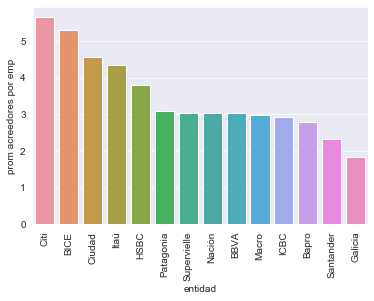

In [9]:
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

df4 = df4.sort_values(by = df4.columns[3], ascending = False) # ordenamos por acreedores promedio

g = sns.barplot(x='entidad', y='prom acreedores por emp', data=df4)
g.set_xticklabels(g.get_xticklabels(), rotation=90); # el ";" evita texto en el output

Habíamos visto que las empresas **toman crédito con 1.6 instituciones en promedio**.

Ahora bien, si lo vemos en cada cartera deudora encontramos que **Citi y BICE** son los bancos de mayor exposición. Por el contrario, **Galicia** parece compartir menos sus deudores.

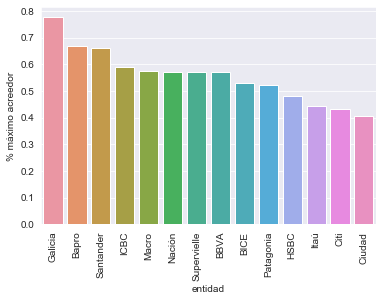

In [10]:
df4 = df4.sort_values(by = df4.columns[2], ascending = False)

g = sns.barplot(x='entidad', y='% máximo acreedor', data=df4)
g.set_xticklabels(g.get_xticklabels(), rotation=90); # el ";" evita texto en el output

¿Cuál es el banco con mayor porcentaje de empresas "máximo" deudor"? **Galicia**. En el otro extremo encontramos a **Ciudad**.

## Más interrogantes...
A todas las inquietudes de la publicación anterior, le sumamos nuevas cuestiones:

¿Es correcto analizar conjuntamente las empresas "mono-deudoras" con las que que toman deuda en varias instituciones? ¿será que Galicia detenta una porción grande de deudores exclusivos?

¿Tiene el mismo "valor" ser máximo deudor en una empresa que debe a dos instituciones que en otra que debe a cinco?

¿Tiene el mismo "valor" ser máximo deudor prestando \\$ 1 MM que prestando \\$ 10.000? 

Si algún día llega la parte tres, vamos a trabajar en la mejor manera de visualizar toda esta información. Áspecto fundamental de todo esto. Muchas gracias!